# Burnt area mapping using Sentinel-2 data  <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook compatible with the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_s2am_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_s2am_ard_3), 
[ga_s2bm_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_s2bm_ard_3)

## Background

### Normalized Burn Ratio

The Normalized Burn Ratio (NBR) is an index that uses the differences in the way healthy green vegetation and burnt vegetation reflect light to find burnt area. 
It is calculated using the following Sentinel-2 bands: Near Infrared/Band 8 and Shortwave Infrared/Band 12. The equation is defined below: 

\begin{equation}
NBR = \frac{(NIR - SWIR)}{(NIR + SWIR)}
\end{equation}

NBR returns values between -1 and 1. 
**Healthy green vegetation will have a high NBR value while burnt vegetation will have a low value**. 
Areas of dry, brown vegetation or bare soil will also return lower NBR values than green vegetation. 

### Delta Normalized Burn Ratio

Change in Normalized Burn Ratio - also called Delta Normalized Burn Ratio (dNBR) - is calculated by subtracting the post-fire NBR value from the baseline NBR value as defined in this equation:

\begin{equation}
dNBR = NBR_{baseline} - NBR_{post fire}
\end{equation}

The dNBR value can be more useful than the NBR alone to determine what is burnt as it shows change from the baseline state. 
**A burnt area will have a positive dNBR value** while an unburnt area will have a negative dNBR value or a value close to zero.

dNBR can also be used to describe burn severity (although this notebook does not look at burn severity). 
A higher severity fire will burn more vegetation, resulting in a higher dNBR. More information on NBR, dNBR and using it to measure burn severity can be found [on the UN-SPIDER knowledge portal](http://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio).

### Defining Burnt From Unburnt Areas

[Rahman et al. 2018](https://doi.org/10.1109/IGARSS.2018.8518449) found a dNBR threshold value of +0.1 appropriate for differentiating burnt from unburnt areas when using Sentinel-2. 
However, some exploration with different threshold levels may be needed to get a good result in areas with different vegetation types. 

In the example presented in this notebook, which covers part of the Clyde Mountain fire in the area north of Batemans Bay, the fire occurred in heavily forested area, which returns a very strong dNBR result. 
Using +0.1 as a threshold here results in many false positives being picked up in the unburnt urban and forest areas where vegetation drying has occurred prior to the fire. 
A much more conservative threshold here of +0.3 produces a better result. 
Keep in mind the limitations of remote sensing and that in an ideal situation ground truth data collected in the location of interest would be used to assist in selecting a threshold.

Some care should also be taken when interpreting results as a number of possible false positives can return a positive dNBR result:

* A lot of smoke in the post burn image can interfere with the dNBR value
* Areas that have been cleared of vegetation by some other means (logging, harvesting, and landslides) towards the end of the baseline period may incorrectly show up as burnt
* Drying out of bright green vegetation such as grasses. 
If a fire event has been preceded by a rapid drying out of vegetation this can result in a low positive dNBR value in areas that have not burnt.


## Description

This notebook calculates the change in Normalized Burn Ratio between a baseline composite image of the pre-fire condition of a selected area and a post-fire event image, in order to find burnt area extent. 
 
The user can change the location over which this notebook is run and specify a different date between which pre and post fire condition will be compared. 
The length of time over which the baseline composite image will be generated can be specified as 3, 6 or 12 months. 
The code in this notebook will automatically generate the composite image over the set length of time using Sentinel-2 data..

The notebook contains the following steps:

1.  Select a location for the analysis
2.  Define fire event date and length of composite image
3.  Load all baseline data
4.  Generate Normalized Burn Ratio for baseline period
5.  Load post-fire data
6.  Generate Normalized Burn Ratio for post fire image
7.  Calculate Delta Normalized Burn Ratio
8.  Apply threshold to Delta Normalized Burn Ratio
9.  Calculate the area burnt
10. Export results as a GeoTIFF

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import datacube
from datacube.utils import cog
from datetime import datetime
from datetime import timedelta
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map
from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37737,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:42959,Total threads: 2
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/34873/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:43111,


### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="Burnt_area_mapping")

### Select location

The selected latitude and longitude will be displayed as a red box on the map below the next cell. 
This map can be used to find coordinates of other places, simply scroll and click on any point on the map to display the latitude and longitude of that location.

In [3]:
# Set the central latitude and longitude
central_lat = -35.653031
central_lon = 150.231667

# Set the buffer to load around the central coordinates
buffer = 0.1

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat, margin=-0.2)

### Define fire event date and length of composite image

Delta Normalized Burn Ratio produces the best result when using a post-fire image that was collected before much re-growth has occured. 
However, images collected while the fire is still active can be obscured by smoke and not show the full burn extent. 
As a result some adjustment of the fire event date entered may be needed to get the best result.

The length of the baseline period can be automatically set to `3, 6 or 12 months`

In [4]:
# Fire event date
fire_date = '2020-01-05'

# Length of baseline period
baseline_length = '3 months'

#### Automaticaly define date range for baseline composite image

In [5]:
# Define dates for loading data
if baseline_length == '12 months':
    time_step = timedelta(days=365)
if baseline_length == '6 months':
    time_step = timedelta(days=182.5)
if baseline_length == '3 months':
    time_step = timedelta(days=91)

# Calculate the start and end date for baseline data load
start_date_pre = datetime.strftime(
    ((datetime.strptime(fire_date, '%Y-%m-%d')) - time_step), '%Y-%m-%d')
end_date_pre = datetime.strftime(
    ((datetime.strptime(fire_date, '%Y-%m-%d')) - timedelta(days=1)),
    '%Y-%m-%d')

# Calculate end date for post fire data load
start_date_post = datetime.strftime(
    ((datetime.strptime(fire_date, '%Y-%m-%d')) + timedelta(days=1)),
    '%Y-%m-%d')
end_date_post = datetime.strftime(
    ((datetime.strptime(fire_date, '%Y-%m-%d')) + timedelta(days=90)),
    '%Y-%m-%d')


# Print dates
print(f'start_date_pre:  {start_date_pre}')
print(f'end_date_pre:    {end_date_pre}')
print(f'fire_date:       {fire_date}')
print(f'start_date_post: {start_date_post}')
print(f'end_date_post:   {end_date_post}')

start_date_pre:  2019-10-06
end_date_pre:    2020-01-04
fire_date:       2020-01-05
start_date_post: 2020-01-06
end_date_post:   2020-04-04


#### Define load parameters

In [6]:
resolution = (-10, 10)
measurements = ['nbart_blue', 'nbart_green', 'nbart_red',
                'nbart_nir_1', 'nbart_swir_3']
min_gooddata = 0.5
output_crs = 'EPSG:3577'

## Load all baseline data

In [7]:
# Load all data in baseline period available from ARD data
baseline = load_ard(dc=dc,
                        products=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
                        x=study_area_lon,
                        y=study_area_lat,
                        time=(start_date_pre, end_date_pre),
                        measurements=measurements,
                        min_gooddata=min_gooddata,
                        output_crs=output_crs,
                        resolution=resolution,
                        group_by='solar_day')


Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step
Filtering to 9 out of 17 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 9 time steps


## Generate Normalized Burn Ratio for baseline period

In [8]:
# Calculate NBR for the baseline images
baseline = calculate_indices(baseline, 
                             index='NBR', 
                             collection='ga_s2_3', 
                             drop=False)

# Compute median using all observations in the dataset along the time axis
baseline_image = baseline.median(dim='time')

# Select NBR
baseline_NBR = baseline_image.NBR

Plot the baseline NBR data side-by-side with an RGB plot of the study area:

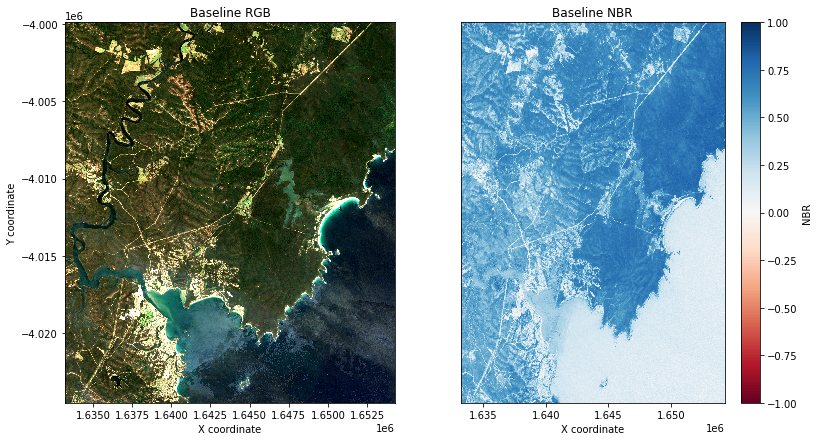

In [9]:
# Set up subplots
f, axarr = plt.subplots(1, 2, figsize=(13, 7), squeeze=False)

# Visualise baseline image as true colour image
rgb(baseline_image, 
    bands=['nbart_red', 'nbart_green', 'nbart_blue'], 
    ax=axarr[0, 0])
axarr[0, 0].set_title('Baseline RGB')
axarr[0, 0].set_xlabel('X coordinate')
axarr[0, 0].set_ylabel('Y coordinate')

# Visualise baseline image as NBR image
baseline_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=axarr[0, 1])
axarr[0, 1].set_title('Baseline NBR')
axarr[0, 1].yaxis.set_visible(False)
axarr[0, 1].set_xlabel('X coordinate');

## Load post-fire data

In [10]:
# Load post-fire data from Sentinel-2A and 2B
post = load_ard(dc=dc,
           products=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
           x=study_area_lon,
           y=study_area_lat,
           time=(start_date_post, end_date_post),
           min_gooddata=min_gooddata,
           measurements=measurements,
           output_crs=output_crs,
           resolution=resolution,
           group_by='solar_day')


Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step
Filtering to 12 out of 18 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 12 time steps


### Generate Normalized Burn Ratio for post fire image

To calculate the post-fire NBR image, we can choose to calculate a median composite using the time-series, or use a single, clear image (if one exists).

Comment out the code you **don't** want to use in the cells below.  

In [11]:
### Use a median composite:

# # Calculate NBR on all post-fire images
post_combined = calculate_indices(post, index='NBR', collection='ga_s2_3', drop=False)

# Calculate the median post-fire image
post_image = post_combined.median(dim='time')

# Select NBR
post_NBR = post_image.NBR
post_NBR


### Or, use a single image:

# # Select the most recent image after the fire
# post_image = post.isel(time=0)

# # Calculate NBR
# post_image = calculate_indices(post_image, index='NBR', collection='ga_s2_3', drop=False)

# # Select NBR
# post_NBR = post_image.NBR

<xarray.DataArray 'NBR' (y: 2457, x: 2107)>
array([[ 0.03306267, -0.06050307,  0.06137184, ..., -0.14643164,
        -0.07091635, -0.12626858],
       [ 0.05032621,  0.03934872,  0.07006962, ..., -0.05963697,
         0.01552465, -0.00515604],
       [ 0.11055277,  0.08027996,  0.10440835, ...,  0.09312639,
         0.02935009,  0.02705541],
       ...,
       [ 0.16665891,  0.15741938,  0.22850606, ...,  0.20183486,
         0.20111732,  0.20325203],
       [ 0.23057222,  0.24860962,  0.253095  , ...,  0.17370893,
         0.20164607,  0.19742487],
       [ 0.20901926,  0.23230752,  0.2371305 , ...,  0.15323855,
         0.21072794,  0.20588236]], dtype=float32)
Coordinates:
  * y            (y) float64 -4e+06 -4e+06 -4e+06 ... -4.024e+06 -4.024e+06
  * x            (x) float64 1.633e+06 1.633e+06 ... 1.654e+06 1.654e+06
    spatial_ref  int32 3577

Plot the post-fire NBR data side-by-side with an RGB plot of the study area:

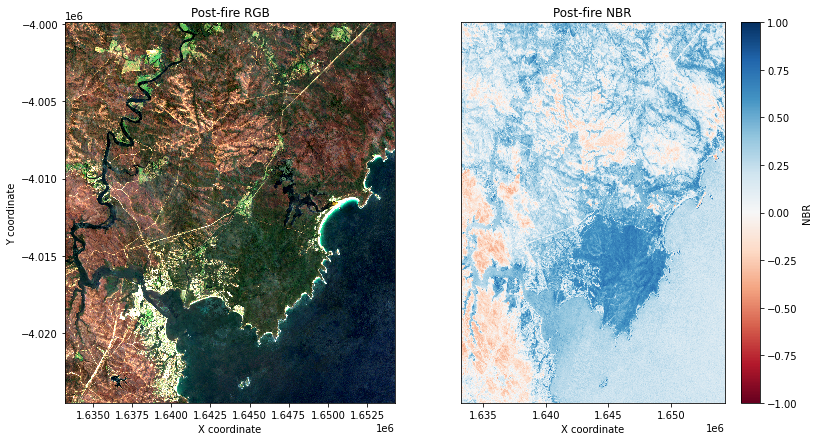

In [12]:
# Set up subplots
f, axarr = plt.subplots(1, 2, figsize=(13, 7), squeeze=False)

# Visualise post-fire image as a true colour image
rgb(post_image, 
    bands=['nbart_red', 'nbart_green', 'nbart_blue'], 
    ax=axarr[0, 0])
axarr[0, 0].set_title('Post-fire RGB')
axarr[0, 0].set_xlabel('X coordinate')
axarr[0, 0].set_ylabel('Y coordinate')

# Visualise post-fire image as NBR image
post_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=axarr[0, 1])
axarr[0, 1].set_title('Post-fire NBR')
axarr[0, 1].yaxis.set_visible(False)
axarr[0, 1].set_xlabel('X coordinate');

## Calculate Delta Normalized Burn Ratio
We can now compute delta NBR by subtracting our post-fire NBR data from our baseline NBR data:

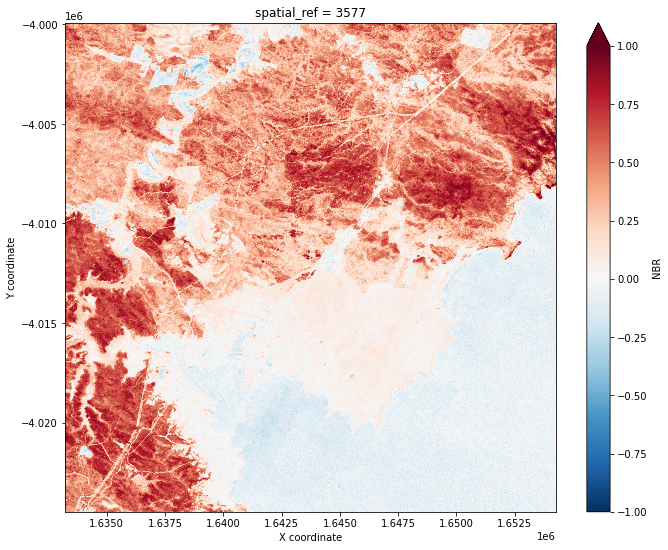

In [13]:
delta_NBR = baseline_NBR - post_NBR

# Visualise dNBR image
delta_NBR.plot(cmap='RdBu_r', vmin=-1, vmax=1, figsize=(11, 9))
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate');

## Apply threshold to Delta Normalized Burn Ratio

Set and apply the NBR threshold.
Here we set it to 0.3, but this will need adjustment depending on the use case.  

In [14]:
# Set threshold
threshold = 0.3

# Apply threshold
burnt = delta_NBR > threshold

# Mask post-fire true colour image
masked = delta_NBR.where(burnt==1)

Re-visualize pre and post-fire true colour images to help adjust the NBR threshold:

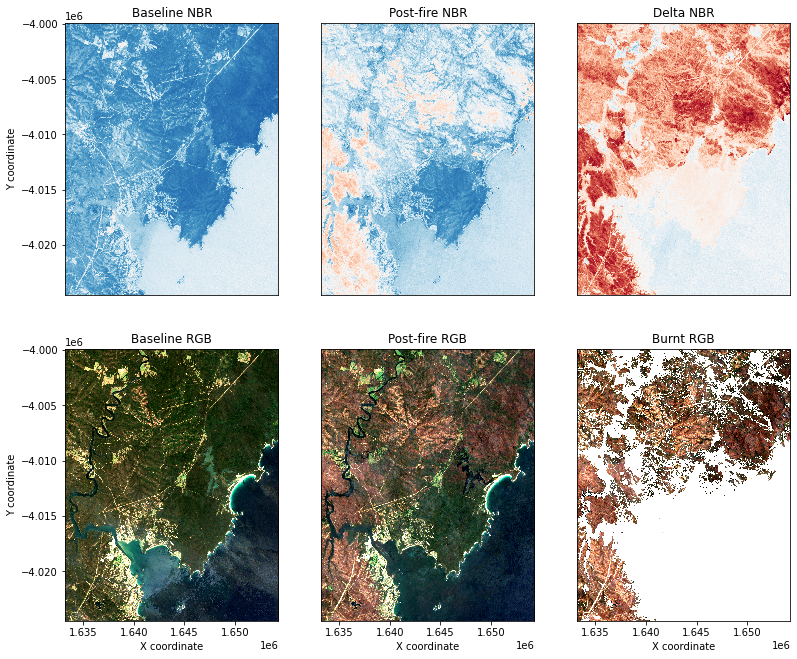

In [15]:
# Set up subplots
f, axarr = plt.subplots(2, 3, figsize=(13, 11))
bands=['nbart_red', 'nbart_green', 'nbart_blue']

baseline_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, 
                  add_colorbar=False, ax=axarr[0, 0])
axarr[0, 0].set_title('Baseline NBR')
axarr[0, 0].set_ylabel('Y coordinate')
axarr[0, 0].xaxis.set_visible(False)

post_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, 
              add_colorbar=False, ax=axarr[0, 1])
axarr[0, 1].set_title('Post-fire NBR')
axarr[0, 1].yaxis.set_visible(False)
axarr[0, 1].xaxis.set_visible(False)

delta_NBR.plot(cmap='RdBu_r', vmin=-1, vmax=1, 
               add_colorbar=False, ax=axarr[0, 2])
axarr[0, 2].set_title('Delta NBR')
axarr[0, 2].yaxis.set_visible(False)
axarr[0, 2].xaxis.set_visible(False)

rgb(baseline_image, bands=bands, ax=axarr[1, 0])
axarr[1, 0].set_title('Baseline RGB')
axarr[1, 0].set_title('Baseline RGB')
axarr[1, 0].set_xlabel('X coordinate')
axarr[1, 0].set_ylabel('Y coordinate')

rgb(post_image, bands=bands, ax=axarr[1,1])
axarr[1, 1].set_title('Post-fire RGB')
axarr[1, 1].set_xlabel('X coordinate')
axarr[1, 1].yaxis.set_visible(False)

rgb(post_image.where(burnt==1), bands=bands, ax=axarr[1, 2])
axarr[1, 2].set_title('Burnt RGB')
axarr[1, 2].set_xlabel('X coordinate')
axarr[1, 2].yaxis.set_visible(False)

## Calculate area burnt

In [16]:
# Constants for calculating burnt area
pixel_length = resolution[1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres

# Area per pixel
area_per_pixel = pixel_length ** 2 / m_per_km ** 2

# Calculate areas
unburnt_area = (delta_NBR <= threshold).sum() * area_per_pixel
burnt_area = burnt.sum() * area_per_pixel
not_nan_area = delta_NBR.notnull().sum() * area_per_pixel
nan_area = delta_NBR.isnull().sum() * area_per_pixel
total_area = unburnt_area + burnt_area + nan_area

print(f'Unburnt area:            {unburnt_area.item():.2f} km^2')
print(f'Burnt area:              {burnt_area.item():.2f} km^2')
print(f'Nan area:                {nan_area.item():.2f} km^2')
print(f'Total area (no nans):    {not_nan_area.item():.2f} km^2')
print(f'Total area (with nans):  {total_area.item():.2f} km^2')

Unburnt area:            308.13 km^2
Burnt area:              209.55 km^2
Nan area:                0.01 km^2
Total area (no nans):    517.68 km^2
Total area (with nans):  517.69 km^2


## Export results to GeoTIFF

The baseline reference image and the post fire image will both be saved as a multiband GeoTIFF with the following bands in the following order: Blue, Green, Red, NIR, SWIR. 

The thresholded burnt area image will be saved as a single band image, where a value of 1 = burnt and a value of 0 = not burnt.

In [17]:
# Define an area name to be used in saved file names
area_name = 'Example'

# Write baseline reference image to multi-band GeoTIFF
cog.write_cog(baseline_image.NBR, f'{area_name}_baseline_image.tif', overwrite=True)

# Write post fire image to multi-band GeoTIFF
cog.write_cog(post_image.NBR, f'{area_name}_post_fire_image.tif', overwrite=True)

# Turn delta NBR into a Xarray Dataset for export to GeoTIFF
cog.write_cog(delta_NBR, f'{area_name}_delta_NBR.tif', overwrite=True)

PosixPath('Example_delta_NBR.tif')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** November 2022

**Compatible datacube version:** 

In [18]:
print(datacube.__version__)

1.8.6


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)